# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [1]:
# import libraries
import re
import numpy as np
import pandas as pd
import pickle
import nltk

from sqlalchemy import create_engine
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

from sklearn.multioutput import MultiOutputClassifier

In [2]:
# load data from database
engine = create_engine("sqlite:///C:\\Users\\DJ\\Documents\\git\\DSND_Term2\\project_files\\09a Disaster_response_pipeline\\workspace\\data\\DisasterResponse.db")
df = pd.read_sql_table('messages', con=engine)

In [3]:
df.head(2)

,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0


In [4]:
X = df['message']
y = df.iloc[:, 4:]

In [5]:
y['related'].unique()
y['related'].replace(2, y['related'].mode().iloc[0], inplace=True)

In [6]:
X = X.head(1000)
y = y.head(1000)

In [7]:
print(type(list(y.columns)))
list(y.columns)

<class 'list'>


['related',
 'request',
 'offer',
 'aid_related',
 'medical_help',
 'medical_products',
 'search_and_rescue',
 'security',
 'military',
 'child_alone',
 'water',
 'food',
 'shelter',
 'clothing',
 'money',
 'missing_people',
 'refugees',
 'death',
 'other_aid',
 'infrastructure_related',
 'transport',
 'buildings',
 'electricity',
 'tools',
 'hospitals',
 'shops',
 'aid_centers',
 'other_infrastructure',
 'weather_related',
 'floods',
 'storm',
 'fire',
 'earthquake',
 'cold',
 'other_weather',
 'direct_report']

In [8]:
type(X.head()), type(y)

(pandas.core.series.Series, pandas.core.frame.DataFrame)

### 2. Write a tokenization function to process your text data

In [9]:
def tokenize(text):  
    
    # Extract all the urls from the provided text
    url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    detected_urls = re.findall(url_regex, text)
    
    # Replace url with a url placeholder string
    for url in detected_urls:
        text = text.replace(url, urlplaceholder )
    
    # didn't remove punctuation, seems to cause error 'list out of range'
    # text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
    
    # normalize text
    tokens = word_tokenize(text)
    
    # didn't remove stop words. slow down the process, also decreases model performance metrics
    # kokens = [w for w in tokens if w not in stopwords.words("english")]
    
    lemmatizer = WordNetLemmatizer()

    clean_tokens = []
    for tok in tokens:
        clean_tok = lemmatizer.lemmatize(tok).lower().strip()
        clean_tokens.append(clean_tok)

    return clean_tokens

In [10]:
print(X[0])
tokenize(X[0])

Weather update - a cold front from Cuba that could pass over Haiti


['weather',
 'update',
 '-',
 'a',
 'cold',
 'front',
 'from',
 'cuba',
 'that',
 'could',
 'pas',
 'over',
 'haiti']

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [11]:
pipeline = Pipeline([
        ('vect', CountVectorizer(tokenizer=tokenize)),
        ('tfidf', TfidfTransformer()),
        ('clf', MultiOutputClassifier(RandomForestClassifier(n_estimators=100))),
    ])

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [13]:
X_train.shape, y_train.shape

((750,), (750, 36))

In [14]:
# took about 5-10 min to run
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function tokenize at...
                 MultiOutputClassifier(estimator=RandomForestClassifier(bootstrap=True,
                                                                        class_weight=None,
                                                                        criterion='gini',
                                                                  

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. 

You can do this by **iterating through the columns** and calling sklearn's `classification_report` on each.

In [15]:
y_pred = pipeline.predict(X_test)

In [16]:
y_pred.shape

(250, 36)

In [17]:
y_test

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
290,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
439,1,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
669,1,1,0,1,0,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,1
383,1,0,0,1,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
393,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
943,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
731,1,1,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
686,1,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
117,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
type(y_pred)

numpy.ndarray

In [21]:
y_pred[:, 0]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [22]:
print(classification_report(y_test.iloc[:, 0], y_pred[:, 0]))

              precision    recall  f1-score   support

           0       0.75      0.07      0.14        40
           1       0.85      1.00      0.92       210

    accuracy                           0.85       250
   macro avg       0.80      0.54      0.53       250
weighted avg       0.83      0.85      0.79       250



In [23]:
# y_test is dataframe, y_pred is numpy array

for i, col in enumerate(y.columns):
    print("[{}]".format(col))
    print(classification_report(y_test.iloc[:, i], y_pred[:, i]))

[related]
              precision    recall  f1-score   support

           0       0.75      0.07      0.14        40
           1       0.85      1.00      0.92       210

    accuracy                           0.85       250
   macro avg       0.80      0.54      0.53       250
weighted avg       0.83      0.85      0.79       250

[request]
              precision    recall  f1-score   support

           0       0.84      0.75      0.79        99
           1       0.85      0.91      0.88       151

    accuracy                           0.84       250
   macro avg       0.84      0.83      0.83       250
weighted avg       0.84      0.84      0.84       250

[offer]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       250

    accuracy                           1.00       250
   macro avg       1.00      1.00      1.00       250
weighted avg       1.00      1.00      1.00       250

[aid_related]
              precision    reca

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



              precision    recall  f1-score   support

           0       0.93      1.00      0.96       233
           1       0.00      0.00      0.00        17

    accuracy                           0.93       250
   macro avg       0.47      0.50      0.48       250
weighted avg       0.87      0.93      0.90       250

[transport]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       239
           1       0.00      0.00      0.00        11

    accuracy                           0.96       250
   macro avg       0.48      0.50      0.49       250
weighted avg       0.91      0.96      0.93       250

[buildings]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96       230
           1       0.00      0.00      0.00        20

    accuracy                           0.92       250
   macro avg       0.46      0.50      0.48       250
weighted avg       0.85      0.92      0.88      

In [24]:
# Overall scores
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='micro')
precision = precision_score(y_test, y_pred, average='micro')
recall = recall_score(y_test, y_pred, average='micro')
print("Random Forest (tuned)")
print("-"*27)
print(f"Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {f1}")

Random Forest (tuned)
---------------------------
Accuracy: 0.16
Precision: 0.8535108958837773
Recall: 0.6141114982578397
F1 Score: 0.7142857142857142


### 6. Improve your model
Use grid search to find better parameters. 

In [116]:
#1 RandomForestClassifier

pipeline = Pipeline([
        ('vect', CountVectorizer(tokenizer=tokenize)),
        ('tfidf', TfidfTransformer()),
        ('clf', MultiOutputClassifier(RandomForestClassifier(n_estimators=100))),
    ])

In [33]:
list(pipeline.get_params().keys())

['memory',
 'steps',
 'verbose',
 'vect',
 'tfidf',
 'clf',
 'vect__analyzer',
 'vect__binary',
 'vect__decode_error',
 'vect__dtype',
 'vect__encoding',
 'vect__input',
 'vect__lowercase',
 'vect__max_df',
 'vect__max_features',
 'vect__min_df',
 'vect__ngram_range',
 'vect__preprocessor',
 'vect__stop_words',
 'vect__strip_accents',
 'vect__token_pattern',
 'vect__tokenizer',
 'vect__vocabulary',
 'tfidf__norm',
 'tfidf__smooth_idf',
 'tfidf__sublinear_tf',
 'tfidf__use_idf',
 'clf__estimator__bootstrap',
 'clf__estimator__class_weight',
 'clf__estimator__criterion',
 'clf__estimator__max_depth',
 'clf__estimator__max_features',
 'clf__estimator__max_leaf_nodes',
 'clf__estimator__min_impurity_decrease',
 'clf__estimator__min_impurity_split',
 'clf__estimator__min_samples_leaf',
 'clf__estimator__min_samples_split',
 'clf__estimator__min_weight_fraction_leaf',
 'clf__estimator__n_estimators',
 'clf__estimator__n_jobs',
 'clf__estimator__oob_score',
 'clf__estimator__random_state',
 '

In [117]:
parameters = {
        'vect__ngram_range': ((1, 1), (1, 2)),
        'vect__max_df': (0.5, 0.75, 1.0),
        'vect__max_features': (None, 5000, 10000),
 #       'tfidf__use_idf': (True, False),
 #       'clf__estimator__n_estimators': [50, 100, 200],
        'clf__estimator__min_samples_split': [2, 3, 4],
        }

cv = GridSearchCV(pipeline, param_grid=parameters, cv=2, n_jobs=2, verbose=2)

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [118]:
model = cv.fit(X_train, y_train)

Fitting 2 folds for each of 54 candidates, totalling 108 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  3.3min
[Parallel(n_jobs=2)]: Done 108 out of 108 | elapsed:  9.2min finished


In [119]:
y_pred = model.predict(X_test)

for i, col in enumerate(y.columns):
    print("[{}]".format(col))
    print(classification_report(y_test.iloc[:, i], y_pred[:, i]))

[related]
              precision    recall  f1-score   support

           0       0.67      0.05      0.09        40
           1       0.85      1.00      0.91       210

    accuracy                           0.84       250
   macro avg       0.76      0.52      0.50       250
weighted avg       0.82      0.84      0.78       250

[request]
              precision    recall  f1-score   support

           0       0.84      0.77      0.80        99
           1       0.86      0.90      0.88       151

    accuracy                           0.85       250
   macro avg       0.85      0.83      0.84       250
weighted avg       0.85      0.85      0.85       250

[offer]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       250

    accuracy                           1.00       250
   macro avg       1.00      1.00      1.00       250
weighted avg       1.00      1.00      1.00       250

[aid_related]
              precision    reca

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.98      1.00      0.99       244
           1       0.00      0.00      0.00         6

    accuracy                           0.98       250
   macro avg       0.49      0.50      0.49       250
weighted avg       0.95      0.98      0.96       250

[death]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       239
           1       0.00      0.00      0.00        11

    accuracy                           0.96       250
   macro avg       0.48      0.50      0.49       250
weighted avg       0.91      0.96      0.93       250

[other_aid]
              precision    recall  f1-score   support

           0       0.76      1.00      0.86       189
           1       0.00      0.00      0.00        61

    accuracy                           0.76       250
   macro avg       0.38      0.50      0.43       250
weighted avg       0.57      0.76      0.65       250


In [122]:
# RandomForestClassifier
# n_estimators = 100
print(model.best_params_)

y_pred = model.predict(X_test)

# Overall scores
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='micro')
precision = precision_score(y_test, y_pred, average='micro')
recall = recall_score(y_test, y_pred, average='micro')
print("RandomForestClassifier (tuned)")
print("-"*27)
print(f"Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {f1}")

{'clf__estimator__min_samples_split': 2, 'vect__max_df': 0.5, 'vect__max_features': 10000, 'vect__ngram_range': (1, 1)}
RandomForestClassifier (tuned)
---------------------------
Accuracy: 0.144
Precision: 0.8528347406513872
Recall: 0.6158536585365854
F1 Score: 0.7152250885179564


### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

In [45]:
#2 KNeighborsClassifier

pipeline = Pipeline([
        ('vect', CountVectorizer(tokenizer=tokenize)),
        ('tfidf', TfidfTransformer()),
        ('clf', MultiOutputClassifier(KNeighborsClassifier())),
    ])

parameters = {
        'vect__ngram_range': ((1, 1), (1, 2)),
        'vect__max_df': (0.5, 0.75, 1.0),
        'vect__max_features': (None, 1000, 5000),
#        'tfidf__use_idf': (True, False),
        'clf__estimator__n_neighbors': (3, 5, 10),
        'clf__estimator__weights': ['uniform', 'distance'],
        'clf__estimator__metric': ['minkowski', 'euclidean'],
        }

cv = GridSearchCV(pipeline, param_grid=parameters, cv=2, n_jobs=2, verbose=2)
model = cv.fit(X_train, y_train)
print(list(model.best_params_))

y_pred = model.predict(X_test)

# Overall scores
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='micro')
precision = precision_score(y_test, y_pred, average='micro')
recall = recall_score(y_test, y_pred, average='micro')
print("KNeighbors (tuned)")
print("-"*27)
print(f"Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {f1}")

Fitting 2 folds for each of 216 candidates, totalling 432 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:   41.0s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:  2.1min
[Parallel(n_jobs=2)]: Done 361 tasks      | elapsed:  4.9min
[Parallel(n_jobs=2)]: Done 432 out of 432 | elapsed:  5.9min finished


{'clf__estimator__metric': 'minkowski', 'clf__estimator__n_neighbors': 3, 'clf__estimator__weights': 'uniform', 'vect__max_df': 0.75, 'vect__max_features': 1000, 'vect__ngram_range': (1, 2)}
KNeighbors (tuned)
---------------------------
Accuracy: 0.156
Precision: 0.7480490523968785
Recall: 0.5844947735191638
F1 Score: 0.6562347188264058


In [115]:
#3 DecisionTreeClassifier

pipeline = Pipeline([
        ('vect', CountVectorizer(tokenizer=tokenize)),
        ('tfidf', TfidfTransformer()),
        ('clf', MultiOutputClassifier(DecisionTreeClassifier())),
    ])

parameters = {
        'vect__ngram_range': ((1, 1), (1, 2)),
        'vect__max_df': (0.5, 0.75, 1.0),
        'vect__max_features': (None, 1000, 5000),
#        'tfidf__use_idf': (True, False),
        'clf__estimator__max_leaf_nodes': (3, 10, 100),
        'clf__estimator__min_samples_split': [2, 3, 4],
        }

cv = GridSearchCV(pipeline, param_grid=parameters, cv=2, n_jobs=2, verbose=2)
model = cv.fit(X_train, y_train)
print(model.best_params_)

y_pred = model.predict(X_test)

# Overall scores
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='micro')
precision = precision_score(y_test, y_pred, average='micro')
recall = recall_score(y_test, y_pred, average='micro')
print("DecisionTree (tuned)")
print("-"*27)
print(f"Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {f1}")

Fitting 2 folds for each of 162 candidates, totalling 324 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:   30.7s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:  1.6min
[Parallel(n_jobs=2)]: Done 324 out of 324 | elapsed:  3.5min finished


{'clf__estimator__max_leaf_nodes': 3, 'clf__estimator__min_samples_split': 2, 'vect__max_df': 0.5, 'vect__max_features': None, 'vect__ngram_range': (1, 1)}
DecisionTree (tuned)
---------------------------
Accuracy: 0.14
Precision: 0.8181818181818182
Recall: 0.627177700348432
F1 Score: 0.7100591715976332


### Add two more features

In [49]:
# add 1st feature

class StartingVerbExtractor(BaseEstimator, TransformerMixin):

    def starting_verb(self, text):
        sentence_list = nltk.sent_tokenize(text)
        for sentence in sentence_list:
            pos_tags = nltk.pos_tag(tokenize(sentence))
            first_word, first_tag = pos_tags[0]
            if first_tag in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']:
                return True
        return False

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_tagged = pd.Series(X).apply(self.starting_verb)
        return pd.DataFrame(X_tagged)

In [50]:
def starting_verb(text):
        sentence_list = nltk.sent_tokenize(text)
        for sentence in sentence_list:
            pos_tags = nltk.pos_tag(tokenize(sentence))
            first_word, first_tag = pos_tags[0]
            if first_tag in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']:
                return True
            else:
                return False

In [65]:
sentence1 = "kick ball"
sentence2 = "played basketball"
sentence3 = "who i am"
sentence4 = "studyed hard"

In [63]:
pos_tags = nltk.pos_tag(tokenize(sentence1))
pos_tags

[('kick', 'VB'), ('ball', 'NN')]

In [66]:
for sen in [sentence1, sentence2, sentence3, sentence4]:
    print(starting_verb(sen))

True
True
False
True


In [67]:
sve = StartingVerbExtractor()

In [68]:
sve.transform(X_train)

,message
365,False
137,False
259,False
289,False
98,False
...,...
20,False
285,True
709,False
960,False


In [69]:
# add 2nd feature

class TextLenghExtractor(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = pd.Series(X).apply(lambda x: len(x))
        return pd.DataFrame(X)

In [72]:
# using FeatureUnion, add two features StartingVerbExtractor and TextLenghExtractor

pipeline = Pipeline([
    ('features', FeatureUnion([

        ('text_pipeline', Pipeline([
            ('vect', CountVectorizer(tokenizer=tokenize)),
            ('tfidf', TfidfTransformer())
        ])),

        ('starting_verb', StartingVerbExtractor()),      
        ('text_length', TextLenghExtractor())
    ])),

    ('clf', MultiOutputClassifier(RandomForestClassifier(n_estimators=100)))
])


In [73]:
# specify parameters for grid search

parameters = {
    'features__text_pipeline__vect__ngram_range': ((1, 1), (1, 2)),
    'features__text_pipeline__vect__max_df': (0.5, 0.75, 1.0),
    'features__text_pipeline__vect__max_features': (None, 5000, 10000),
#    'features__text_pipeline__tfidf__use_idf': (True, False),
    'clf__estimator__n_estimators': [50, 100, 200],
    'clf__estimator__min_samples_split': [2, 3],

    'features__transformer_weights': (
        {'text_pipeline': 1, 'starting_verb': 0.5, 'text_length': 0.5},
        {'text_pipeline': 1, 'starting_verb': 0.5, 'text_length': 1},
        {'text_pipeline': 1, 'starting_verb': 1, 'text_length': 1},
    )
}

In [75]:
cv = GridSearchCV(pipeline, param_grid=parameters, cv=2, n_jobs=2, verbose=2)

model = cv.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(model.best_params_)

# Overall scores
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='micro')
precision = precision_score(y_test, y_pred, average='micro')
recall = recall_score(y_test, y_pred, average='micro')
print("RandomForestClassifier (tuned)")
print("-"*27)
print(f"Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {f1}")

Fitting 2 folds for each of 324 candidates, totalling 648 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  3.2min
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed: 14.7min
[Parallel(n_jobs=2)]: Done 361 tasks      | elapsed: 42.1min
[Parallel(n_jobs=2)]: Done 644 tasks      | elapsed: 84.5min
[Parallel(n_jobs=2)]: Done 648 out of 648 | elapsed: 85.4min finished


['clf__estimator__min_samples_split', 'clf__estimator__n_estimators', 'features__text_pipeline__vect__max_df', 'features__text_pipeline__vect__max_features', 'features__text_pipeline__vect__ngram_range', 'features__transformer_weights']
RandomForestClassifier (tuned)
---------------------------
Accuracy: 0.144
Precision: 0.8539458186101295
Recall: 0.6315331010452961
F1 Score: 0.7260891337005508


In [77]:
model.best_params_

{'clf__estimator__min_samples_split': 3,
 'clf__estimator__n_estimators': 50,
 'features__text_pipeline__vect__max_df': 0.5,
 'features__text_pipeline__vect__max_features': 5000,
 'features__text_pipeline__vect__ngram_range': (1, 1),
 'features__transformer_weights': {'text_pipeline': 1,
  'starting_verb': 1,
  'text_length': 1}}

### 9. Export your model as a pickle file

In [78]:
pickle.dump(cv, open('workspace\models\classifier_jupyter.pkl', 'wb'))

In [79]:
loaded_model = pickle.load(open('workspace\models\classifier_jupyter.pkl', 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.144


### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.

### 11. Plotting

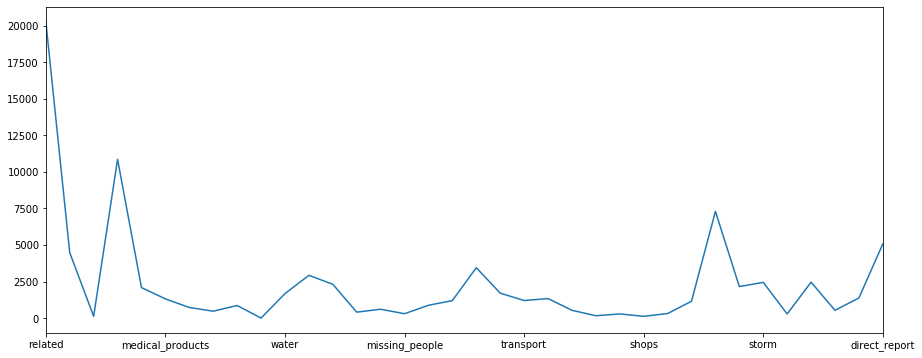

In [112]:
import matplotlib.pyplot as plt
%matplotlib inline

df.drop('id', axis=1).sum(axis=0, numeric_only=True).plot(figsize=(15, 6))

In [113]:
category_counts = df.drop('id', axis=1).sum(axis=0, numeric_only=True).sort_values()

In [114]:
category_names = list(df1.index)

In [131]:
df.groupby('original')['id'].count()

original
                             a                                                                                                1
                           a                                                                                                  1
                          !   a                                                                                               1
                    a                                                                                                         1
              SE TALUQ RAKHTA            3     a                                                                              1
                                                                                                                             ..
zn nazon, comcel ak delma 30 poko janmen ka jwenn distribisyon, tanpri voye jwen nan zon sa yo. mesi pou tout mesaj sa yo.    1
zone kafou new york bezwen tant                                                                

In [132]:
?WorldCloud

Object `WorldCloud` not found.
